# Working with raw MRI data
Code adapted from: https://github.com/ismrmrd/ismrmrd-paper

This is an example Jupyter Notebook with simple code for reconstructing an MRI image from raw data in the ISMRMRD format, intended for educational purposes only. For details and more advanced methods check [Inati et al. ISMRM Raw Data Format: A Proposed Standard for MRI Raw Datasets](https://pmc.ncbi.nlm.nih.gov/articles/PMC4967038/) and resources provided by the [ISMRMRD development team](https://ismrmrd.github.io/apidocs/1.5.0/).

### Prerequisites 

If you are working on Binder, you can start immediately with loading packages and reading in the provided dataset. 

If you are working in your local python environment we first need to install the ismrmrd package. To do this, run the following command in your terminal/command prompt. Note that this requires git to be installed on your system.

```bash
pip install git+https://github.com/ismrmrd/ismrmrd-python.git

### Downloading data

If you are working on Binder, you don't need to download data, as there is a dataset (testdata.h5) already provided. Alternatively you can also upload a different dataset.

You can find raw data on [mridata.org](mridata.org):
There, go to Data List. Use the Advanced Search to search for the UUID:


**3dc8a1a2-5d1e-4200-b04c-98f8b4b62a72**

 which is the example dataset provided on Binder. 

This script should also work for any of the other datasets from the projects _NYU Machine Learning_ or _Stanford 2D FSE_.

You can download a dataset without sign up or login. Place it in the folder where this Jupyter Notebook is located and rename it to testdata.h5

### Loading packages

In [ ]:
# run this to import the necessary packages

import numpy as np
from numpy.fft import fftshift, ifftshift, fftn, ifftn
import matplotlib.pyplot as plt
import ismrmrd
import ismrmrd.xsd
import h5py

### Loading k-space data from ISMRMRD files

In [4]:
# Adapt this if your dataset is named differently
fname = 'testdata' 
fname = 'C:/Users/marle/Professional/NOS local/FT MRT Tutorial/rawData/standford_foot'

# Find the dataset
dset = ismrmrd.Dataset('%s.h5'%fname, 'dataset', create_if_needed=False)

# Read the header containing metadata about the dataset
header = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header())

# Read encoding parameters
enc = header.encoding[0]

# Number of encoding steps in each directions
eNx = enc.encodedSpace.matrixSize.x
eNy = enc.encodedSpace.matrixSize.y
eNz = enc.encodedSpace.matrixSize.z

# Number of Slices
if enc.encodingLimits.slice != None:
    nslices = enc.encodingLimits.slice.maximum + 1
else: 
    # Because this Notebook strongly simplified
    # it is not compatible with non-slice encoded (i.e. 3D FT encoded) data
    raise ValueError("Data is not slice encoded")

# Number of Repetitions 
if enc.encodingLimits.repetition != None:
    nreps = enc.encodingLimits.repetition.maximum + 1
else:
    nreps = 1

# Number of Contrasts (e.g. T1, T2...)
if enc.encodingLimits.contrast != None:
    ncontrasts = enc.encodingLimits.contrast.maximum + 1
else:
    ncontrasts = 1

# Number of Coils 
acq = dset.read_acquisition(0)
ncoils = acq.active_channels

# Initialiaze an empty storage array
all_data = np.zeros((nreps, ncontrasts, nslices, ncoils, eNz, eNy, eNx), dtype=np.complex64)

# Loop through all the acquisitions and store data in the array
for acqnum in range(dset.number_of_acquisitions()):
    acq = dset.read_acquisition(acqnum)

    # Ignore noise scans
    if acq.isFlagSet(ismrmrd.ACQ_IS_NOISE_MEASUREMENT):
        continue

    # Read acquisition parameters
    rep = acq.idx.repetition
    contrast = acq.idx.contrast
    slice = acq.idx.slice
    ky = acq.idx.kspace_encode_step_1
    kz = acq.idx.kspace_encode_step_2

    # Store data in appropriate place in the array
    all_data[rep, contrast, slice, :, kz, ky, :] = acq.data

# Close the dataset    
dset.close()

(-0.5, 255.5, 383.5, -0.5)

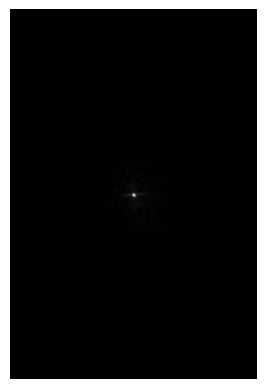

In [19]:
# We will now select a set of parameters to extract a simple k-space matrix

rep = 0 #can be anywhere between 0 and nreps-1
contrast = 0 #accordingly with nconstrasts
coil = 0

# For the provided testdata set this is a nice slice
slice = 19

# Because we use slice encoding, we can set kz to 0
kz = 0 

slice_data = all_data[rep,contrast,slice,coil,kz,:,:]   

# Let's take a look at our k-space

# For plotting, we take the magnitude
# We also need to flip the axes because of how imshow interprets them
k_plot = np.abs(slice_data.T)

plt.figure()
plt.imshow(k_plot, cmap='gray')
plt.axis('off')

### Reconstructing an image

(-0.5, 255.5, 383.5, -0.5)

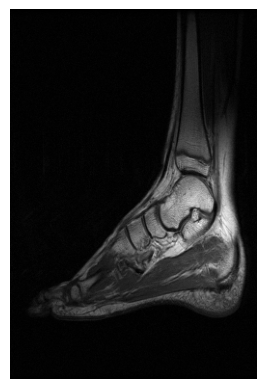

In [20]:
# As the k-space is not in the expected shape for fft,
# we need to shift it with fftshift, then perform inverse fft, and shift again
img = fftshift(ifftn(ifftshift(slice_data)))

# For plotting we again take the magnitude and transpose
img_plot = np.abs(img.T)

plt.figure()
plt.imshow(img_plot, cmap='gray')
plt.axis('off')

### Optionally export the k-space matrix
To continue working with the k-space data with different softare, e.g. in R, we export it to a file on disk.

This is now a simple 2d-matrix with complex entries but without any metadata. For consistency, we are using the .h5 format for storage again.

In [ ]:
fname = 'k_slice.h5' # Optionally adapt file name

# Store the real and imaginary parts as separate matrices
with h5py.File(fname, 'w') as f:
    f.create_dataset('/K_slice_real', data=np.real(slice_data), dtype='float64')
    f.create_dataset('/K_slice_imag', data=np.imag(slice_data), dtype='float64')

f.close()
  